In [1]:
from utils import * 

In [ ]:
# First want to look at the metabolic potential of the genomes. What genes are present?
# Relevant metabolism things: (https://www.cell.com/trends/microbiology/fulltext/S0966-842X(25)00031-9)
# (1) Iron reduction (https://pmc.ncbi.nlm.nih.gov/articles/PMC7005843/)
# (2) Nitrate reduction
# (3) Humic acid reduction 
# (4) Methanotrophy 
# Denitrification (nitrate to nitrite) https://www.kegg.jp/module/M00529
# Might also be worth looking into genes for stress response. 

interproscan_df = load_interproscan().rename(columns={'id':'gene_id'}).drop(columns=['length', 'start', 'stop'])
interproscan_df = interproscan_df[interproscan_df.e_value < 1e-5].copy()
interproscan_df = interproscan_df[is_mp(interproscan_df)].copy()

In [3]:
processes = dict()
processes['methanotrophy'] = ['methyl+coenzyme', 'methane+monooxygenase']
# Worried about using Nap genes because they seem like they might overlap with other cytochromes. 
processes['nitrate_reduction'] = ['narG', 'narH', 'nari', 'narK', 'narJ'] #, 'napa', 'napb', 'napc', 'napD', 'napF', 'napG', 'napH', 'napK', 'napL', 'napM', 'napS']
processes['iron_reduction_pilus'] = ['archaeal+pilin']
# processes['iron_reduction_pilus'] = ['pilA', 'pilB', 'pilC', 'pilD', 'pilT', 'pilM']
processes['iron_reduction_omc'] = ['omcA', 'omcC', 'omcB', 'omcE', 'omcF', 'mtrA', 'mtrB', 'mtrC']

In [4]:

database_patterns = dict()
database_patterns[r'PF\d+'] = 'pfam'
database_patterns[r'PTHR\d+'] = 'panther'
database_patterns[r'NF\d+'] = 'ncbifam'
database_patterns[r'IPR\d+'] = 'interpro'
database_patterns[r'PIRSF\d+'] = 'pirsf'
database_patterns[r'TIGR\d+'] = 'ncbifam'
database_patterns[r'cd\d+'] = 'cdd'
database_patterns[r'PS\d+'] = 'prosite'
database_patterns[r'G[\d\.]+'] = 'gene3d'
database_patterns[r'SSF\d+'] = 'ssf'
database_patterns[r'SFLD\d+'] = 'sfld'

def _interpro_get_metadata(accession:str):

    database = None
    for database_pattern, database in database_patterns.items():
        if re.match(database_pattern, accession) is not None:
            break

    info = dict()
    info['accession'] = accession
    info['database'] = database
    
    try:
        url = f'https://www.ebi.ac.uk/interpro/api/entry/{database}/{accession}'
        result = requests.get(url).text 
        result = json.loads(result)['metadata']
        info['name'] = result['name']['name']
        info['short_name'] = result['name']['short']
        info['description'] = result['description']['text']
        info['database'] = database
    except:
        pass 
    return info

def interpro_get_metadata(process, queries, n_hits:int=20):
    accessions = list()
    url = 'https://www.ebi.ac.uk/ebisearch/ws/rest/interpro?query={query}&size={n_hits}' # Reliability kind of drops off after the first 20 or so queries.
    for query in queries:
        result = requests.get(url.format(query=query, n_hits=n_hits)).text
        accessions += re.findall(r'id="([a-zA-Z0-9\.]+)"', result)
    accessions = np.unique(accessions) # Make sure there are no duplicates. 
    print(f'Obtained {len(accessions)} accessions for {process}')

    interpro_metadata_df = list()
    for accession in tqdm(accessions, desc='Collecting InterPro metadata.'):
        info = _interpro_get_metadata(accession)
        interpro_metadata_df.append(info)
    interpro_metadata_df = pd.DataFrame(interpro_metadata_df)
    interpro_metadata_df = interpro_metadata_df.drop_duplicates('accession')
    interpro_metadata_df.to_csv(f'../data/interpro_{process}.csv')

# for process, queries in processes.items():
#     interpro_get_metadata(process, queries)
# interpro_get_metadata('iron_reduction_pilus', processes['iron_reduction_pilus'])

genes = dict()
for process in processes:
    accessions = pd.read_csv(f'../data/interpro_{process}.csv', usecols=['accession']).accession.values 
    mask = interproscan_df.signature_accession.isin(accessions)
    genes[process] = set(zip(interproscan_df[mask].target_name, interproscan_df[mask].gene_id))


In [5]:
len(genes['nitrate_reduction'])

10

In [6]:
interproscan_df[interproscan_df.signature_description.str.contains('pil')]

,gene_id,md5,signature_analysis,signature_accession,signature_description,e_value,status,date,interpro_accession,interpro_description,target_name
15679,7_59,aaed9b8d48a4de93a7612602d23b8e4a,Pfam,PF07790,"Archaeal Type IV pilin, N-terminal",7.800000e-23,T,14-12-2025,IPR012859,"Archaeal Type IV pilin, N-terminal",mp_1
16177,22_50,fa36c8ed8628f4055939e48e3aacb6d8,Pfam,PF01478,"Prepilin type IV endopeptidase, peptidase domain",4.000000e-11,T,14-12-2025,IPR000045,"Prepilin type IV endopeptidase, peptidase domain",mp_4
18434,99_10,b42233a6367239fad9c7777a14c48c19,Pfam,PF07790,"Archaeal Type IV pilin, N-terminal",2.700000e-14,T,14-12-2025,IPR012859,"Archaeal Type IV pilin, N-terminal",mp_4
584,1_1,3131beb42da248447a6385d8b1b23d9a,Pfam,PF01478,"Prepilin type IV endopeptidase, peptidase domain",9.600000e-11,T,14-12-2025,IPR000045,"Prepilin type IV endopeptidase, peptidase domain",mp_2
163,36_19,90990c7467ee93537468c1efb8420f9c,Pfam,PF07790,"Archaeal Type IV pilin, N-terminal",4.100000e-15,T,14-12-2025,IPR012859,"Archaeal Type IV pilin, N-terminal",mp_1
3784,119_3,8ab903a481b52d890f00cc3b45265dde,Pfam,PF07790,"Archaeal Type IV pilin, N-terminal",2.700000e-16,T,14-12-2025,IPR012859,"Archaeal Type IV pilin, N-terminal",mp_3
4098,119_2,f547b0841ce6f5425bb62f27c05fa9d5,Pfam,PF07790,"Archaeal Type IV pilin, N-terminal",1.900000e-20,T,14-12-2025,IPR012859,"Archaeal Type IV pilin, N-terminal",mp_3
2360,40_10,1a71f0f95da99cdba47e4cdbc1af9ffd,Pfam,PF07790,"Archaeal Type IV pilin, N-terminal",5.600000e-12,T,14-12-2025,IPR012859,"Archaeal Type IV pilin, N-terminal",mp_3
601,3_93,af1cf4dc6f1f3826f67b13a783c5e669,Pfam,PF07790,"Archaeal Type IV pilin, N-terminal",1.500000e-14,T,14-12-2025,IPR012859,"Archaeal Type IV pilin, N-terminal",mp_5
600,6_34,5287eaab09e69508468e55d4e294b9c8,Pfam,PF07790,"Archaeal Type IV pilin, N-terminal",1.200000e-11,T,14-12-2025,IPR012859,"Archaeal Type IV pilin, N-terminal",mp_4


In [8]:
# Want to take a closer look at which Methanoperedens genes are expressed generally, in each reactor, to get a sense of the metabolism in each reactor. 
# If I'm not doing differential expression analysis, I don't think I need to filter out low read counts. 
metat_df = metat_load()
metat_df = metat_df[is_mp(metat_df)].copy()
metat_df['sample_id'] = metat_df.sample_id.str.replace('_metat', '')
metat_df = metat_df.merge(interproscan_df.sort_values('e_value').drop_duplicates(['target_name', 'gene_id']), on=['target_name', 'gene_id'], how='left')
metat_df = pd.concat([metat_filter(df, threshold=1, min_samples=1, field='read_count') for _, df in metat_df.groupby('target_name', group_keys=True)])

ref_genes = {f'mp_{i}':[] for i in range(1, 6)}
for gene in genes['methanotrophy']:
    ref_genes[gene[0]].append(gene)

metat_df =  metat_normalize(metat_df, ref_genes=ref_genes)
# metat_df['read_count'] = metat_df.read_count + 1
# metat_df['rpkm'] = metat_df.read_count / (metat_df.length / 1e3) / (metat_df.library_size / 1e6)


filter_: Keeping 2758 out of 2875 total genes for mp_1.
filter_: Keeping 475 out of 613 total genes for mp_2.
filter_: Keeping 2800 out of 3055 total genes for mp_3.
filter_: Keeping 3141 out of 3537 total genes for mp_4.
filter_: Keeping 2487 out of 2733 total genes for mp_5.
_metat_normalize_alr: No reference reads for mp_1 in n_bottom_2024.
_metat_normalize_alr: No reference reads for mp_2 in n_bottom_2024.
_metat_normalize_alr: No reference reads for mp_4 in n_bottom_2024.
_metat_normalize_alr: No reference reads for mp_3 in n_middle_2024.
_metat_normalize_alr: No reference reads for mp_4 in n_middle_2024.


/home/prichter/Documents/rotations/banfield/src/metat.py:76: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  normalization_factors[target_name] = gmean(read_counts)
/home/prichter/Documents/rotations/banfield/src/metat.py:76: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  normalization_factors[target_name] = gmean(read_counts)


In [ ]:
metat_df

,index,gene_id,contig,start,end,strand,length,read_count,sample_id,target_name,...,signature_accession,annotation,e_value,status,date,interpro_accession,interpro_description,read_count_original,normalization_factor_alr,read_count_normalized_alr
0,11500,1_1,SR-VP_05_06_2024_ck_bottom_scaffold_83,3,91,+,89,0.002796,ck_bottom_2024,mp_1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,234.015822,-11.334811
1,11501,1_2,SR-VP_05_06_2024_ck_bottom_scaffold_83,193,698,-,506,0.002796,ck_bottom_2024,mp_1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,234.015822,-11.334811
2,11502,1_3,SR-VP_05_06_2024_ck_bottom_scaffold_83,1040,2322,-,1283,7.999114,ck_bottom_2024,mp_1,...,G3DSA:1.10.238.260,-,1.500000e-23,T,14-12-2025,-,-,8,234.015822,-3.376058
3,11503,1_4,SR-VP_05_06_2024_ck_bottom_scaffold_83,2402,3057,-,656,0.002796,ck_bottom_2024,mp_1,...,G3DSA:3.60.15.10,Ribonuclease Z/Hydroxyacylglutathione hydrolas...,2.600000e-46,T,14-12-2025,IPR036866,Ribonuclease Z/Hydroxyacylglutathione hydrolas...,0,234.015822,-11.334811
4,11504,1_5,SR-VP_05_06_2024_ck_bottom_scaffold_83,3092,3630,-,539,0.002796,ck_bottom_2024,mp_1,...,G3DSA:3.60.21.10,Metallo-dependent phosphatase-like,5.000000e-36,T,14-12-2025,IPR029052,Metallo-dependent phosphatase-like,0,234.015822,-11.334811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11656,103527,60_2,SR-VP_05_06_2024_N_top_scaffold_785694,611,1206,-,596,2440.293570,n_top_2025,mp_5,...,G3DSA:2.60.40.1120,-,9.300000e-17,T,14-12-2025,-,-,2441,285.509903,2.145597
11657,103528,61_1,SR-VP_05_06_2024_N_top_scaffold_857493,747,1003,+,257,0.002013,n_top_2025,mp_5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,285.509903,-11.862225
11658,103530,62_1,SR-VP_05_06_2024_N_top_scaffold_914341,7,710,-,704,5.998264,n_top_2025,mp_5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,285.509903,-3.862807
11659,103531,62_2,SR-VP_05_06_2024_N_top_scaffold_914341,939,1102,-,164,0.002013,n_top_2025,mp_5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,285.509903,-11.862225


Total genes for mp_1: 3
Total genes for mp_2: 1
Total genes for mp_3: 2
Total genes for mp_4: 1
Total genes for mp_5: 3


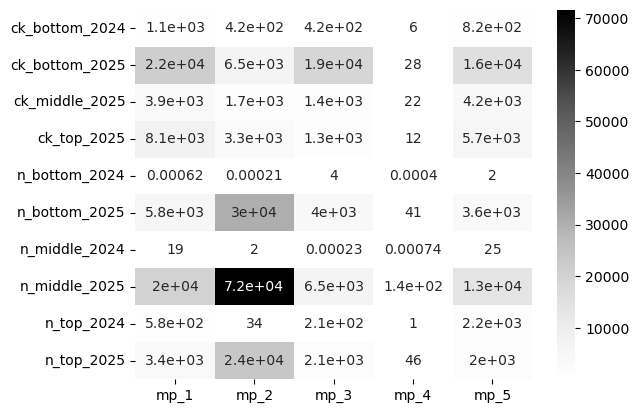

In [12]:
# Heatmap figure with strain on the x-axis and sample on the y-axis. One figure for each type of metabolism, 
# and each square is the proportion of genes related to that metabolism expressed in that particular sample
def figure(metat_df:pd.DataFrame, genes=None):
    
    fig, ax = plt.subplots()

    target_names = ['mp_1', 'mp_2', 'mp_3', 'mp_4', 'mp_5']
    sample_ids = metat_df.sample_id.unique()

    figure_df = pd.DataFrame(index=sample_ids, columns=target_names)
    metat_df = metat_df[get_genes(metat_df, genes)].copy()
    # metat_df = metat_df[metat_df.target_name.isin(target_names)].copy()

    for target_name, df in metat_df.groupby('target_name'):
        total = df.gene_id.nunique() # Total number of genes present associated with the metabolism. 
        print(f'Total genes for {target_name}:', total)
        figure_df[target_name] = df[df.read_count > 0].groupby('sample_id').size()
        figure_df[target_name] = df[df.read_count > 0].groupby('sample_id').read_count.sum() 

        # get_gmean = lambda df : gmean(df.read_count.values)
        # figure_df[target_name] = df[df.read_count_original > 0].groupby('sample_id').read_count_normalized_alr.mean() 

    figure_df = figure_df.fillna(0) #.astype(int)
    figure_df = figure_df.sort_index()
    sns.heatmap(figure_df, cmap='Grays', annot=True)
    return figure_df


figure_df = figure(metat_df, genes=genes['methanotrophy'])


In [ ]:
# Maybe the best way to think about expression is just as a presence or absence matrix, perhaps with a score corresponding to 
# the number of samples the gene is detected in. Probably should look at the ck and n reactors separately, not sure yet about
# 2024 versus 2025 in the n reactor, considering there are obvious metabolic changes.

id_cols = ['gene_id', 'target_name']
df = metat_df.drop_duplicates(id_cols)[id_cols].copy()
# Maks sure to account for the pseudocount here, so make sure everything is > 1 not >= 1.
df = df.merge(metat_df.groupby(id_cols).apply(lambda df : ((df.reactor == 'ck') & (df.read_count > 1)).sum(), include_groups=False).reset_index(name='ck_sample_count'), on=id_cols)
df = df.merge(metat_df.groupby(id_cols).apply(lambda df : ((df.reactor == 'n') & (df.read_count > 1)).sum(), include_groups=False).reset_index(name='n_sample_count'), on=id_cols)
df['total'] = df.ck_sample_count + df.n_sample_count
df = df.sort_values('total')

interproscan_df = interproscan_df.drop_duplicates(['target_name', 'gene_id']).rename(columns={'signature_description':'annotation'})
df = df.merge(interproscan_df[['target_name', 'gene_id', 'annotation']], on=['target_name', 'gene_id'], how='left')
df['annotation'] = df.annotation.fillna('-')
# df['annotation'] = [get_annotation(row.gene_id, row.target_name) for row in tqdm(list(df.itertuples()), 'Collecting annotations from InterProScan data...')]

In [ ]:
# There are 6 nitrate reactor samples and 4 methane-only reactor samples. 
# There is overall more expression in the ck reactor, so genes which are detected in n reactor and not ck are more likely to be ck-only. However,
# lack of read data does not mean lack of expression. 

# Does it make sense to cluster before normalizing?

# Very few genes expressed in all 10 samples, which is not surprising considering the high variability in read depth. 

# How to go about looking at these data?
print('Num. Methanoperedens genes:', df.target_name.str.startswith('mp_').sum())
print('Num. Methanoperedens genes expressed in the n reactor only:', (df.target_name.str.startswith('mp_') & (df.n_sample_count > 0) & (df.ck_sample_count == 0)).sum())
print('Num. Methanoperedens genes expressed in the ck reactor only:', (df.target_name.str.startswith('mp_') & (df.ck_sample_count > 0) & (df.n_sample_count == 0)).sum())
print('Num. Methanoperedens genes expressed in the both reactors:', (df.target_name.str.startswith('mp_') & (df.ck_sample_count > 0) & (df.n_sample_count > 0)).sum())

Num. Methanoperedens genes: 12813
Num. Methanoperedens genes expressed in the n reactor only: 1416
Num. Methanoperedens genes expressed in the ck reactor only: 2189
Num. Methanoperedens genes expressed in the both reactors: 7450


In [ ]:
# I think it would be safe to assume that broad changes in metabolism would be conserved across strains, though perhaps not minute 
# changes associated with a loss of ECEs (these might be specific to the ECE host, if indeed there is only one or two of these). 

# To make analysis either (though losing strain-level resolution), going to cluster the Methanoperedens sequences.

fasta_df = list()
for path in glob.glob('../data/data/mp_*.fa'):
    target_name = os.path.basename(path).replace('.fa', '')
    df = FASTAFile().from_file(path).to_df(parse_description=False)
    df.index = [f'{target_name}.{gene_id}' for gene_id in df.index]
    fasta_df.append(df)
fasta_df = pd.concat(fasta_df)
FASTAFile().from_df(fasta_df).write('../data/mp.fa')

cluster_df = pd.read_csv('../data/mp_cluster.tsv', names=['rep_gene_id', 'gene_id'], sep='\t') # Clustered at 80% identity. 
cluster_id_map = {rep_gene_id:i for i, rep_gene_id in enumerate(cluster_df.rep_gene_id.unique())}
cluster_df['cluster_id'] = cluster_df.rep_gene_id.map(cluster_id_map).astype(int)
cluster_df['target_name'] = [gene_id.split('.')[0] for gene_id in cluster_df.gene_id]
cluster_df['gene_id'] = [gene_id.split('.')[1] for gene_id in cluster_df.gene_id]

FileNotFoundError: [Errno 2] No such file or directory: '../data/mp_cluster.tsv'

In [ ]:
# Also beneficial to look at differential expression between reactors, more statistically sound. 

In [ ]:
counts = df[df.target_name.str.startswith('mp_') & (df.n_sample_count > 2) & (df.ck_sample_count == 0) & (df.annotation != '-')].annotation.value_counts()
counts[counts > 1].index.tolist()

# counts = df[df.target_name.str.startswith('mp_') & (df.ck_sample_count > 1) & (df.n_sample_count == 0) & (df.annotation != '-')].annotation.value_counts()
# counts[counts > 1].index.tolist()

['S-adenosyl-L-methionine-dependent methyltransferase superfamily',
 'P-loop containing nucleoside triphosphate hydrolase',
 'Flavoprotein-like superfamily',
 'Aldolase-type TIM barrel',
 'Hexapeptide repeat proteins',
 'Prokaryotic membrane lipoprotein lipid attachment site profile',
 'FAD/NAD(P)-binding domain superfamily',
 'Type I restriction enzyme EcoKI-like, methylase subunit, N-terminal domain superfamily',
 'Cytochrome C3',
 'Nucleotidyltransferase superfamily',
 'Type II CAAX prenyl endopeptidase Rce1-like',
 'Flavocytochrome C3; Chain A',
 'Multiple antibiotic resistance (MarC)-related',
 'Glutamate synthase, alpha subunit, C-terminal domain superfamily',
 'Winged helix-like DNA-binding domain superfamily',
 'ABC-2 type transporter, transmembrane domain',
 'MetI-like superfamily',
 'Cytosolic phospholipase A2 catalytic domain',
 'Nucleotide-diphospho-sugar transferases',
 'Cupredoxin',
 'Molybdopterin cofactor biosynthesis C (MoaC) domain superfamily',
 'PAS domain',
 'Immun

(-0.16095730797542745, 1.0)

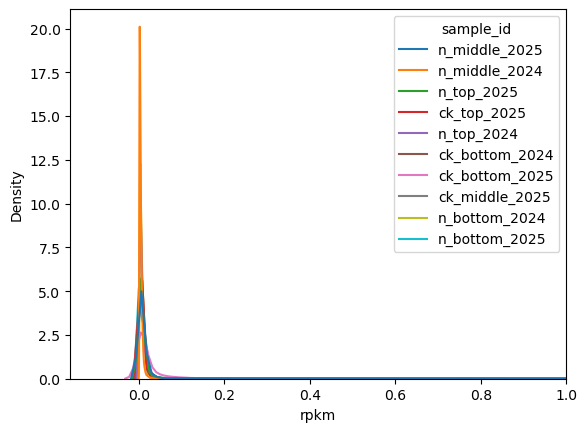

In [ ]:
fig, ax = plt.subplots()
figure_df = metat_df.copy()
figure_df['rpkm'] = np.log10(figure_df.rpkm + 1)
sns.kdeplot(figure_df, x='rpkm', hue='sample_id')
ax.set_xlim(xmax=1)

# Probably want to look for things that are expressed in both 

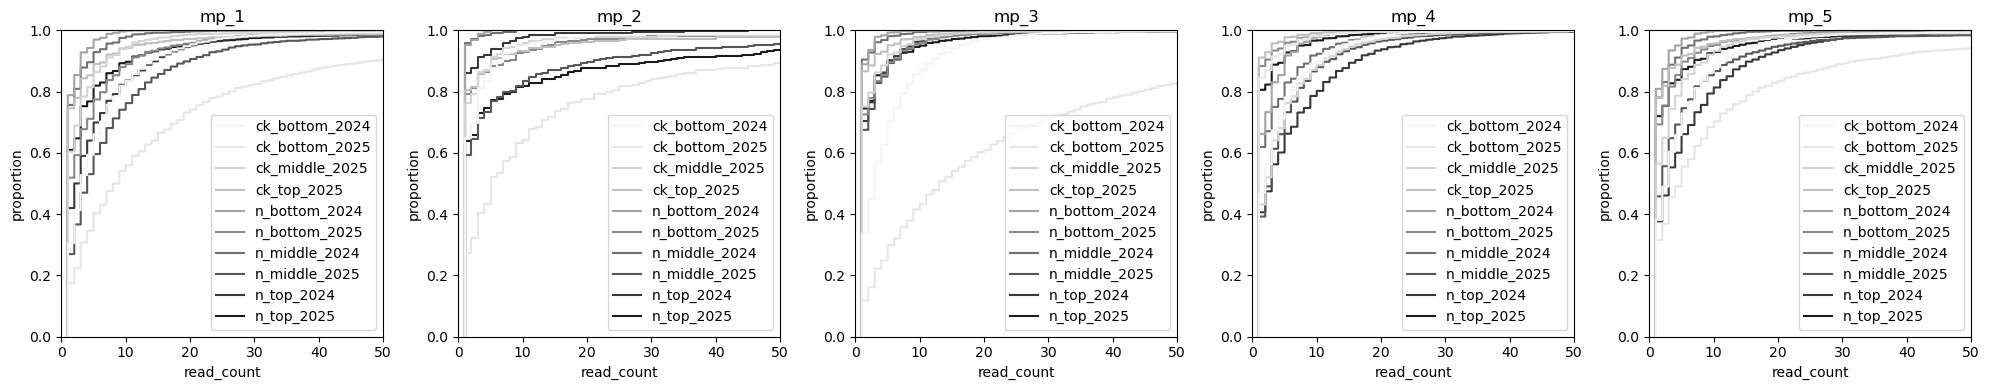

In [ ]:
# How best to normalize this data? Would be good to compare the relative expression levels across samples, so probably
# a good idea to use ALR normalization again, at least for Methanoperedens. Not sure what to do about the Borgs. 

def plot_read_counts(metat_df, ax=None, title:str='', legend:bool=True):
    figure_df = metat_df.sort_values('sample_id')
    figure_df = figure_df[figure_df.sample_id != 'n_bottom_2024_metat'].copy() # Sample with small library size.
    ax.set_title(title)
    sns.ecdfplot(figure_df, x='read_count', hue='sample_id', palette='Grays', ax=ax, legend=legend)
    ax.get_legend().set_title('')
    ax.set_xlim(xmin=0, xmax=50)
    ax.set_ylabel('proportion')

fig, axes = plt.subplots(figsize=(20, 4), ncols=5)

for ax, (target_name, df) in zip(axes, list(metat_df[metat_df.target_name.str.startswith('mp_')].groupby('target_name'))):
    plot_read_counts(df, ax=ax, title=target_name) #, legend=(target_name == 'mp_5'))

fig.tight_layout()
plt.show()


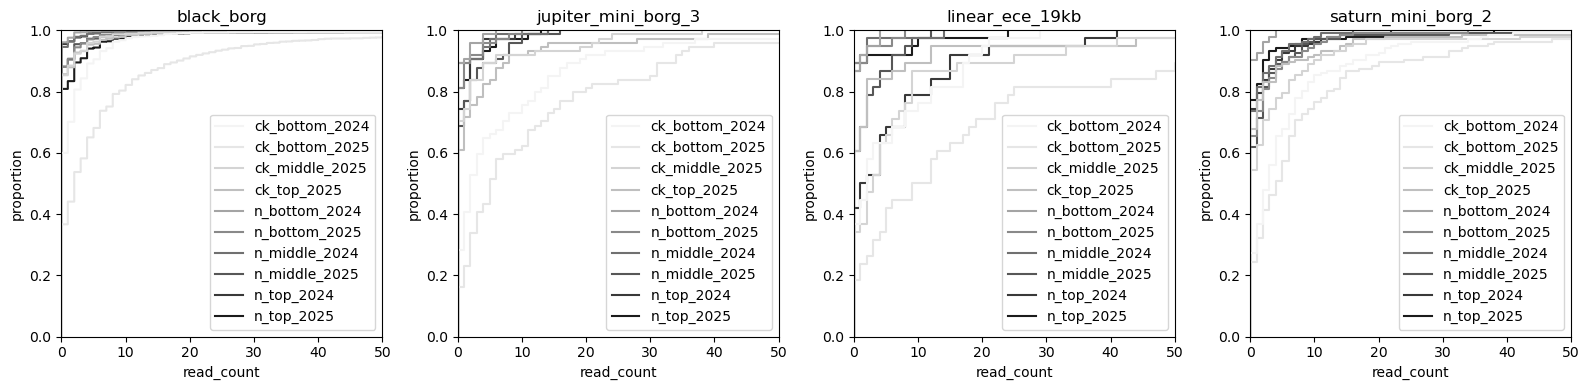

In [ ]:
# Also need to look at Borg expression to figure out how on earth to normalize it. 

fig, axes = plt.subplots(figsize=(16, 4), ncols=4)

target_names = ['black_borg', 'saturn_mini_borg_2', 'jupiter_mini_borg_3', 'linear_ece_19kb']
for ax, (target_name, df) in zip(axes, list(metat_df[metat_df.target_name.isin(target_names)].groupby('target_name'))):
    plot_read_counts(df, ax=ax, title=target_name) #, legend=(target_name == 'mp_5'))

fig.tight_layout()
plt.show()


In [ ]:
# When looking at differential expression, did not need to normalize by gene length because I was just comparing a gene to itself. However, 
# will need to normalize by length when looking at overall expression. I think I should still be normalizing according to the housekeeping genes to
# compare across samples, also probably normalize the Borg genes to the housekeeping genes?

# How do I compare the Borg activity across samples?

ece_metat_df = metat_df[~metat_df.target_name.str.startswith('mp_')].copy()
ece_metat_df = ece_metat_df.merge(interproscan_df, on=['target_name', 'gene_id'], how='left')
ece_metat_df['signature_description'] = ece_metat_df.signature_description.fillna('none')
ece_metat_df = ece_metat_df.sort_values('e_value').drop_duplicates(['target_name', 'sample_id', 'gene_id'])

ece_metat_df[(ece_metat_df.read_count > 0)].gene_id.value_counts()

gene_id
1_23     23
1_19     22
1_17     21
1_38     21
1_20     21
         ..
1_638     1
1_571     1
1_192     1
3_140     1
1_576     1
Name: count, Length: 1400, dtype: int64

In [ ]:
metat_summary_df = metat_load_summary()
metat_summary_df[metat_summary_df.target_name == 'linear_ece_19kb']

,n_assigned,n_unassigned_unmapped,n_unassigned_no_features,n_unassigned_ambiguity,sample_id,target_name,total,library_size
93,20,2,26,6,n_middle_2024_metat,linear_ece_19kb,52,334480934
94,63,7,13,11,n_middle_2025_metat,linear_ece_19kb,87,294446328
95,293,31,208,40,ck_middle_2025_metat,linear_ece_19kb,541,250326764
96,45,0,24,7,n_top_2025_metat,linear_ece_19kb,76,229018512
97,154,10,75,15,ck_top_2025_metat,linear_ece_19kb,244,274392272
98,12,0,12,6,n_bottom_2024_metat,linear_ece_19kb,30,177712338
99,18,0,24,0,n_bottom_2025_metat,linear_ece_19kb,42,295624030
100,220,23,329,52,ck_bottom_2024_metat,linear_ece_19kb,601,286635956
101,229,68,328,71,n_top_2024_metat,linear_ece_19kb,628,303075226
102,1341,48,357,192,ck_bottom_2025_metat,linear_ece_19kb,1890,273454876


In [ ]:
metat_df

,gene_id,contig,start,end,strand,length,read_count,sample_id,target_name,coverage,library_size,location,reactor,year
0,1_1,SR-VP_05_06_2024_coassembly_scaffold_31318,4,185,-,182,0,n_top_2025,jupiter_mini_borg_1,0.0,229018512,top,n,2025
1,1_2,SR-VP_05_06_2024_coassembly_scaffold_31318,150,292,-,143,0,n_top_2025,jupiter_mini_borg_1,0.0,229018512,top,n,2025
2,1_3,SR-VP_05_06_2024_coassembly_scaffold_31318,296,603,-,308,0,n_top_2025,jupiter_mini_borg_1,0.0,229018512,top,n,2025
3,1_4,SR-VP_05_06_2024_coassembly_scaffold_31318,608,876,-,269,0,n_top_2025,jupiter_mini_borg_1,0.0,229018512,top,n,2025
4,1_5,SR-VP_05_06_2024_coassembly_scaffold_31318,892,1379,-,488,0,n_top_2025,jupiter_mini_borg_1,0.0,229018512,top,n,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194452,28_3,SR-VP_05_06_2024_coassembly_scaffold_1960231,1198,1265,-,68,0,ck_middle_2025,jupiter_mini_borg_2,0.0,250326764,middle,ck,2025
194453,29_1,SR-VP_05_06_2024_coassembly_scaffold_2084789,2,1218,-,1217,0,ck_middle_2025,jupiter_mini_borg_2,0.0,250326764,middle,ck,2025
194454,30_1,SR-VP_05_06_2024_coassembly_scaffold_2142760,4,98,+,95,0,ck_middle_2025,jupiter_mini_borg_2,0.0,250326764,middle,ck,2025
194455,30_2,SR-VP_05_06_2024_coassembly_scaffold_2142760,281,1098,+,818,0,ck_middle_2025,jupiter_mini_borg_2,0.0,250326764,middle,ck,2025


In [ ]:
# # Use HMMs from the FeGenie library to look for genes related to iron reduction. 
# hmmsearch_df = list()

# for path in glob.glob('../data/data/*.fa'):
#     target_name = os.path.basename(path).replace('.fa', '')
#     output_path = f'../data/hmmsearch/{target_name}-iron_reduction.tbl'
#     if not os.path.exists(output_path):
#         subprocess.run(f'hmmsearch --cpu 16 --tblout {output_path} ../data/hmms/iron_reduction.hmm {path} ', shell=True, check=True)
#     cols = ['query_id', 'query_description', 'target_id', 'target_decription', 'e_value', 'score', 'bias']
#     df = pd.read_csv(output_path, sep=r'\s+', comment='#', usecols=np.arange(len(cols)), names=cols)
#     if len(df) == 0:
#         continue
#     df['target_name'] = target_name
#     hmmsearch_df.append(df)

# hmmsearch_df = pd.concat(hmmsearch_df)
# hmmsearch_df = hmmsearch_df[is_mp(hmmsearch_df)].copy()
# hmmsearch_df = hmmsearch_df[hmmsearch_df.e_value < 1e-5].sort_values('e_value').copy()
# hmmsearch_df = hmmsearch_df.drop_duplicates(['target_name', 'query_id'])

In [ ]:
# interproscan_df[interproscan_df.signature_description.str.contains('nitrate|nitrite', case=False) & (interproscan_df.target_name == 'mp_2')].sort_values('gene_id')
# interproscan_df[interproscan_df.signature_description.str.contains('iron', case=False) & (interproscan_df.target_name == 'mp_1')].sort_values('gene_id')

# # These three proteins seem to exist in an operon. 
# # DMSO/Nitrate reductase chaperone (PF02613)
# # Nitrate reductase beta subunit (PTHR43518)
# # MopB Nitrate-R-NarG-like domain-containing protein (cd02750)

# # mp_5 14_65 14_66 14_63
# # mp_1 24_19 24_21 24_22
# # mp_4 74_3 74_4
# # mp_2 none
# # mp_3 231_6

# # https://pmc.ncbi.nlm.nih.gov/articles/PMC9295563/